In [1]:
from FeatureRelated.feature_generator import Feature_generator
from LabelRelated.label_generator import Label_generator 
from FeatureRelated.feature_data_holder import FeatDataHolder
from LabelRelated.label_data_holder import LabelDataHolder
import numpy as np
from Vis import LabelVis, ClassificationVis
from Util import DataUtils as dutil

/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')
/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
"""
Class that brings together feature and label side to provide all data needed for classification.
Synchronizes the data.
This class is not designed to be used elsewhere. Data should be generated and analysed here, then saved to file using the DataUtil class.
"""
class DataProvider:
    """
    Init function. Start and end time are set for a time period I checked manually to be more or less okay.
    Creates classes to hold label and feature data in memory and classes to create feats and labels.
    Input: draw bool, if we want to visualize the happy/non-happy ratio et al.
    """
    def __init__(self, draw = False):
        realtime_start = 29413 #this is 8h, 10min and 13s into day 4
        video_start = realtime_start - 29344 # 29344 is the beginning of recordings of video data (see /home/emil/data/sync_data)
        self.duration = 37820+4500 #in seconds, of course
        self.feat_data = FeatDataHolder('/data2/users/stepeter/Preprocessing/processed_cb46fd46_4.h5',start=realtime_start, duration=self.duration)
        self.label_data = LabelDataHolder('/home/emil/data/hdf_data/cb46fd46_7_imp_columns.hdf',video_start,video_start+self.duration, col = 'Happy_predicted' )
        self.annot_data = LabelDataHolder('/home/emil/data/hdf_data/cb46fd46_7_imp_columns.hdf',video_start,video_start+self.duration, col = 'annotated')
        self.featuregen = Feature_generator(self.feat_data)
        self.lablegen = Label_generator(self.label_data,mask=self.featuregen.mask_bin)
        self.annotsgen = Label_generator(self.annot_data,mask=self.featuregen.mask_bin) #this is for conf mat later
        self.draw = draw

    #get datasets
    """
    Function to generate the feats and labels, given the input hyperparas
    Input: Windowsize, sliding window, start and end (in s), train bool, variance to be explained, cutoff if classification.
    Output: Features, Labels
    """
    def get_data(self,wsize=100,sliding=10,s_sample=0,e_sample=None, train=True, expl_var=95, cutoff = None):
        if e_sample == None:
            e_sample = self.duration-1
        #train data
        x = self.featuregen.generate_features(wsize = wsize, start=s_sample,end=e_sample,expl_variance=expl_var,train=train,sliding_window=sliding)
        y,rat = self.lablegen.generate_labels(wsize = wsize, start=s_sample,end=e_sample, sliding_window=sliding, cutoff=cutoff)
        annots, _ = self.annotsgen.generate_labels(wsize=wsize, start=s_sample,end=e_sample, sliding_window=sliding, cutoff=cutoff)
        if self.draw:
            LabelVis.plot_happy_ratio(y,rat)
            LabelVis.plot_happy_ratio(annots,_)
            preds = y[~np.isnan(y)] ### this is for the confusion matrix between human annotations and openface labels
            annots = annots[~np.isnan(y)]
            preds = preds[~np.isnan(annots)]
            annots = annots[~np.isnan(annots)] ###
            ClassificationVis.conf_mat(preds, annots)
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        return x,y


In [3]:
data = DataProvider(draw=True)

Warning. Start and end points for the given dataset is still manually set for patient c46fd46, day 4.
Warning. Some datapoints are manually set to be bad. This only holds true for pat cb46fd46, day 4.


In [19]:
#generate data here, to parallelize
sliding = 10
wsize = 100
s_sample = 0
e_sample = 30000
s_sample_ev = 30000
e_sample_ev = 35000
cutoff=.2
configs =dict()
configs['sliding']=sliding
configs['wsize']=wsize
configs['s_sample']=s_sample
configs['e_sample']=e_sample
configs['s_sample_ev']=s_sample_ev
configs['e_sample_ev']=e_sample_ev
configs['cutoff']=cutoff

Warning. A whole chunck of 100 s of data was thrown away here, starting at s 0. Check if this is correct
Warning. A whole chunck of 100 s of data was thrown away here, starting at s 10. Check if this is correct
Warning. A whole chunck of 100 s of data was thrown away here, starting at s 20. Check if this is correct
Warning. A whole chunck of 100 s of data was thrown away here, starting at s 2600. Check if this is correct
Warning. A whole chunck of 100 s of data was thrown away here, starting at s 3400. Check if this is correct
Warning. A whole chunck of 100 s of data was thrown away here, starting at s 4200. Check if this is correct
Warning. A whole chunck of 100 s of data was thrown away here, starting at s 14400. Check if this is correct
Warning. A whole chunck of 100 s of data was thrown away here, starting at s 16500. Check if this is correct
Setting up PCA on current data range...
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Ch

/home/emil/OpenMindv2/LabelRelated/label_generator.py:37: RuntimeWarning: Mean of empty slice
  happy_portion = np.nanmean(np.array(self.pred_bin, dtype = 'float'),axis = 1)
/home/emil/OpenMindv2/LabelRelated/label_generator.py:61: RuntimeWarning: Mean of empty slice
  self.labels += [np.nanmean(curr_data)]


Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.
Whole chunk of NaNs. Check this again.


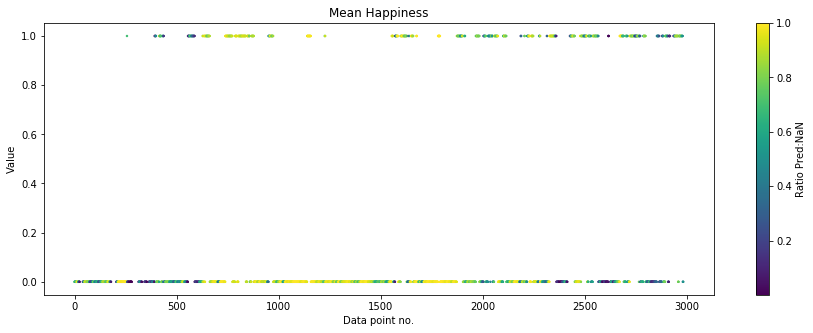

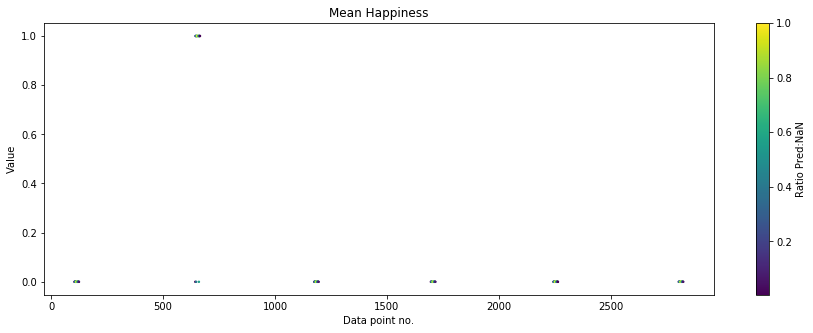

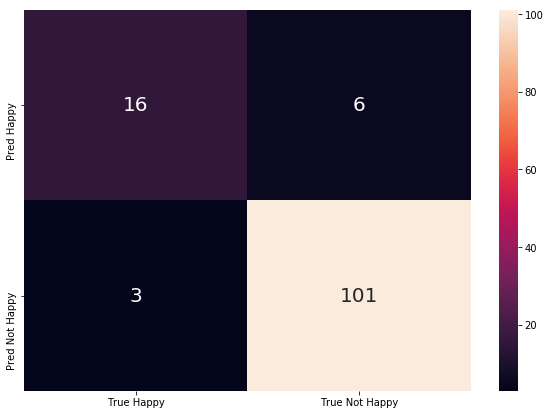

/home/emil/OpenMindv2/LabelRelated/label_generator.py:37: RuntimeWarning: Mean of empty slice
  happy_portion = np.nanmean(np.array(self.pred_bin, dtype = 'float'),axis = 1)
/home/emil/OpenMindv2/LabelRelated/label_generator.py:61: RuntimeWarning: Mean of empty slice
  self.labels += [np.nanmean(curr_data)]


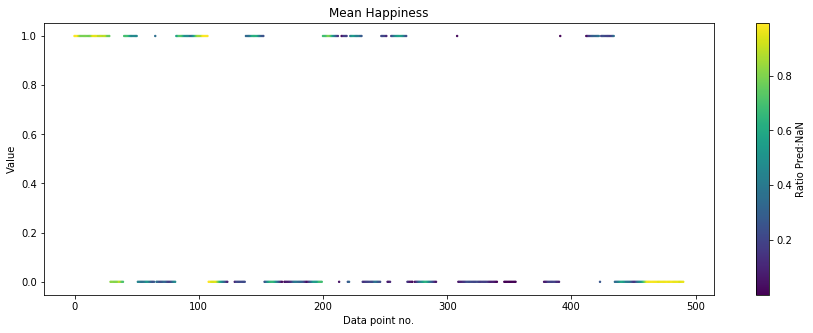

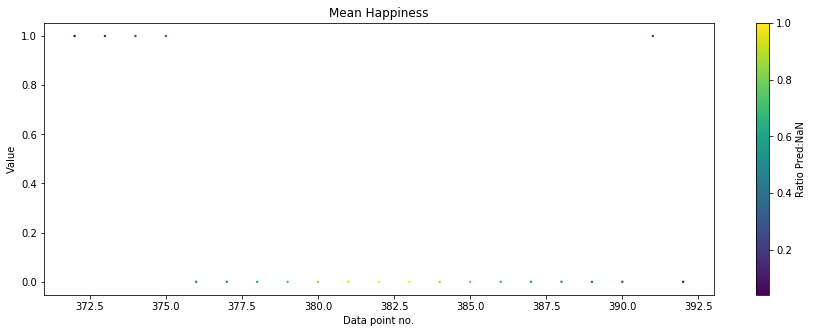

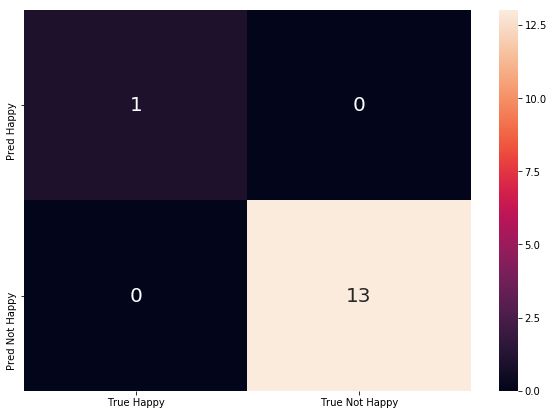

In [20]:
#for wsize in [50,100,200]:
x,y = data.get_data(wsize=wsize,sliding=sliding,s_sample=s_sample,e_sample=e_sample,cutoff=cutoff)
x_ev,y_ev =  data.get_data(wsize=wsize,sliding=sliding,s_sample=s_sample_ev,e_sample=e_sample_ev, train= False, cutoff=cutoff)


In [6]:
import matplotlib.pyplot as plt

In [7]:
x.shape

(39, 25)

In [18]:
np.median(abs(x))

2.0436628159947747

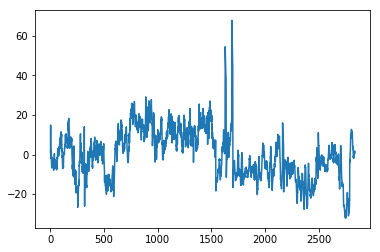

In [25]:
plt.plot(x[:,0])

In [26]:
dutil.save_data_to_file(x,y,x_ev,y_ev,configs)

/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['x', 'y', 'x_ev', 'y_ev']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [ ]:
# #this is to find cutoff

# bla = DataProvider(draw=True)
# ma = DataProvider(draw=True, col ='annotated')

# y = bla.get_data(sliding=10)
# my = ma.get_data(sliding=10)

# thresh = .3
# for thresh in [.2]:
#     y_class = y.copy()
#     my_class = my.copy()
#     y_class_nans = np.isnan(y_class)
#     my_class_nans = np.isnan(my_class)
#     print(y_class_nans)
#     y_class[y_class<thresh]=0
#     y_class[y_class>0]=1
#     y_class[y_class_nans]=np.nan
#     my_class[my_class<thresh]=0
#     my_class[my_class>0]=1
#     my_class[my_class_nans]=np.nan

#     LabelVis.plot_nan_ratio(my_class)
#     LabelVis.plot_nan_ratio(y_class)

#     ynonan =y_class[~my_class_nans]
#     mynonan = my_class[~my_class_nans]
#     mynonan = mynonan[~np.isnan(ynonan)]
#     ynonan = ynonan[~np.isnan(ynonan)]

#     ClassificationVis.conf_mat(mynonan,ynonan)